## Exploratiory Data Analysis
### Importing libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
# setting up filepath, importing data
path = r'C:\Users\Richárd\Desktop\CareerFoundry\Data Immersion\Achievement 6\project\Data'
supply_chain = pd.read_pickle(os.path.join(path, 'clean_supply_chain.pkl'))

In [3]:
supply_chain.columns

Index(['type', 'shipping_days_real', 'shipping_days_scheduled',
       'profit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_id', 'customer_segment', 'customer_state',
       'department_id', 'department_name', 'market', 'order_city',
       'order_country', 'order_date', 'order_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_region', 'order_state',
       'order_status', 'product_id_card', 'product_name', 'product_price',
       'product_status', 'shipping_date', 'shipping_mode'],
      dtype='object')

In [4]:
# creating subset by omitting Ids, time-series, geographic variables
subset = supply_chain[['type', 'shipping_days_real', 'shipping_days_scheduled', 'profit_per_order', 'sales_per_customer', 'delivery_status', 'late_delivery_risk', 'category_name', 'customer_segment', 'department_name', 'order_item_discount', 'order_item_discount_rate', 'order_item_profit_ratio', 'order_item_quantity', 'sales', 'order_status', 'product_name', 'product_price', 'product_status', 'shipping_mode',]]
subset.head()

,type,shipping_days_real,shipping_days_scheduled,profit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_name,customer_segment,department_name,order_item_discount,order_item_discount_rate,order_item_profit_ratio,order_item_quantity,sales,order_status,product_name,product_price,product_status,shipping_mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Consumer,Fitness,13.110000,0.04,0.29,1,327.75,COMPLETE,Smart watch,327.75,0,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Consumer,Fitness,16.389999,0.05,-0.80,1,327.75,PENDING,Smart watch,327.75,0,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,Consumer,Fitness,18.030001,0.06,-0.80,1,327.75,CLOSED,Smart watch,327.75,0,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Home Office,Fitness,22.940001,0.07,0.08,1,327.75,COMPLETE,Smart watch,327.75,0,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Corporate,Fitness,29.500000,0.09,0.45,1,327.75,PENDING_PAYMENT,Smart watch,327.75,0,Standard Class


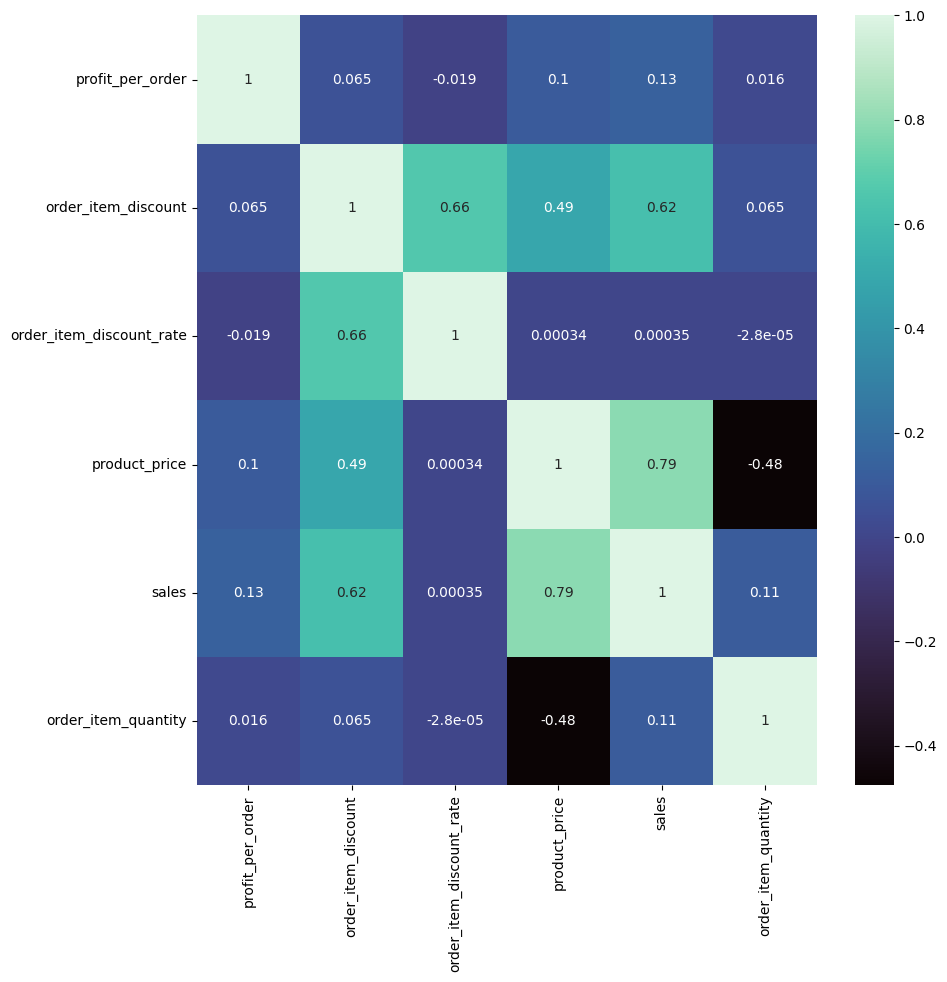

In [5]:
# creating heatmap about meaningful numeric variables
cmap = sns.color_palette("mako", as_cmap=True)
f,ax = plt.subplots(figsize=(10,10))
corr = sns.heatmap(subset[['profit_per_order','order_item_discount', 'order_item_discount_rate', 'product_price', 'sales', 'order_item_quantity']].corr(), annot = True, ax = ax, cmap = cmap)

### Observations
- perhaps the most meaningful information uncovered here is the moderate positive relationship between the quantity of items ordered and amount of discount on products. It suggests that discounts are effective incentives to order more products, and quantifying that could be helpful insight.
- At the same time order quantity seems to be in moderate negative correlation with price, suggesting that it is unlikely for customers to order more than one expensive product at one time.
- Discount amounts also show a moderately strong correlation with profit per order and sales. This seems interesting on surface but probably caused by generally more expensive products having bigger discounts. The ever so slight negative correlation of profit and discount rate confirms this
- product price and profit per order barely show any correlation. This suggests that expensive and inexpensive products drive profits equally, at least on a product by product basis. This means that the amount of products sold matters more than their price range in terms of net profit

<AxesSubplot: >

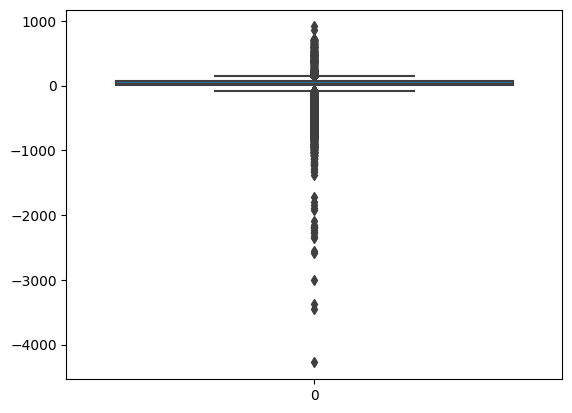

In [6]:
# Sanity check
sns.boxplot(supply_chain['profit_per_order'])

### Cleaning vol.2
- Upon a closer look at negative profit-ratio orders, it seems absolutely certain that there is a mistake in the cases of those orders.
- However still no systematic component was to be found. 
- The problem occurs at the order_profit_ratio column, since profit = order_item_profit_ratio * sales_per_customer
- These skew analysis severley (sometimes claiming that the seller loses 4000$+ on a single laptop sale) so need to be addressed
- The mean of the positive profit ratio is the most reasonable value to impute, so I have decided to replace the negative profit ratio values with the mean of the positive ones

In [7]:
# checking descriptive statistics to chose what to impute
not_weird = supply_chain[supply_chain['order_item_profit_ratio'] > 0]

In [8]:
# checking if discount rates should be taken into account when computing profit ratio - there seems to be no correlation
not_weird['order_item_profit_ratio'].corr(not_weird['order_item_discount_rate'])

0.000991685955163041

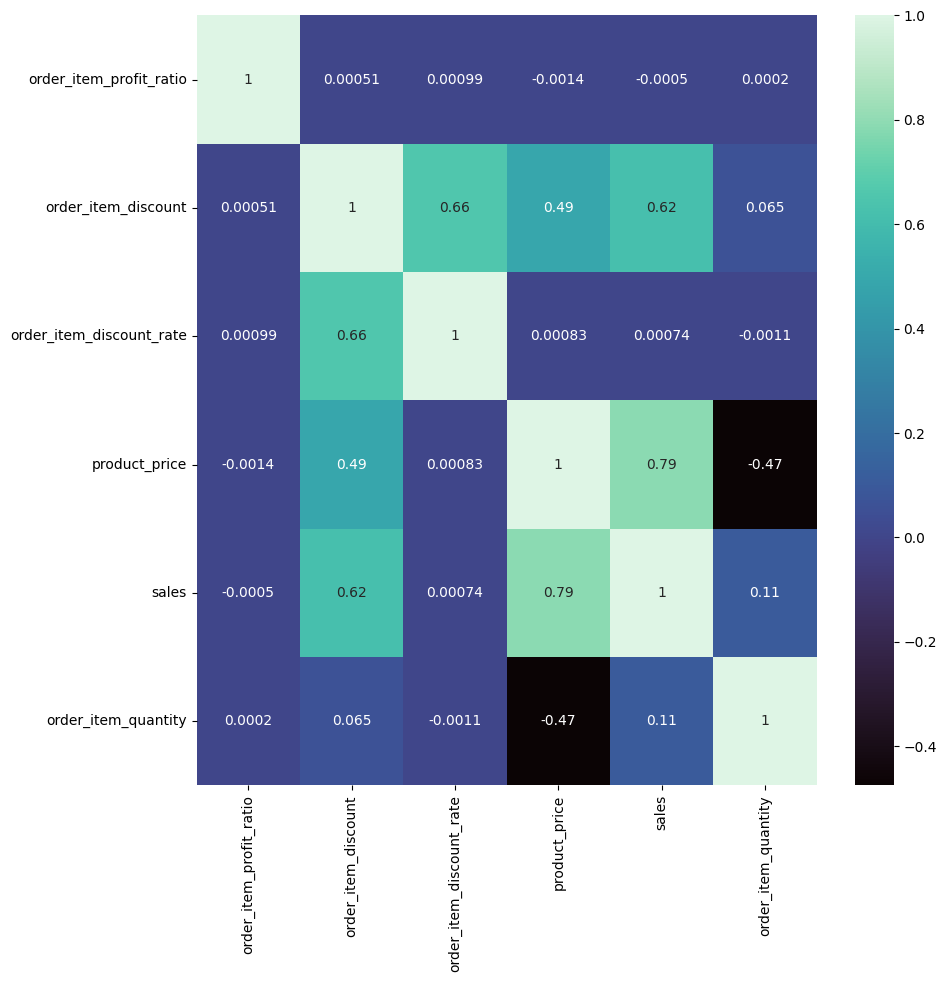

In [9]:
# checking other possible correlations - still nothing that should be taken into account so going with imputing the mean seems to be the best option
cmap = sns.color_palette("mako", as_cmap=True)
f,ax = plt.subplots(figsize=(10,10))
corr = sns.heatmap(not_weird[['order_item_profit_ratio','order_item_discount', 'order_item_discount_rate', 'product_price', 'sales', 'order_item_quantity']].corr(), annot = True, ax = ax, cmap = cmap)

In [10]:
# checking some other options
not_weird['order_item_profit_ratio'].describe()

count    145558.000000
mean          0.294694
std           0.139776
min           0.010000
25%           0.190000
50%           0.310000
75%           0.410000
max           0.500000
Name: order_item_profit_ratio, dtype: float64

In [11]:
# checking some other options
not_weird['order_item_profit_ratio'].mode()

0    0.48
Name: order_item_profit_ratio, dtype: float64

In [12]:
# checking some other options
supply_chain['order_item_profit_ratio'].median()

0.270000011

In [13]:
# function for imputing the mean of positive profit rations (0.29) to negative profit ratios
def profit_imputer(x):
    if x < 0:
        return 0.29
    else:
        return x


In [14]:
# impoting the the actual column
correct_profit_ratios = supply_chain['order_item_profit_ratio'].apply(profit_imputer)

In [15]:
# recalculating the profit_per_order column
profit = []
ratios = correct_profit_ratios.to_list()
sales_list = supply_chain['sales_per_customer'].to_list()


for x in range(len(ratios)):
    profit.append(round((sales_list[x] * ratios[x]), 2))

# print(profit)

[91.25, 90.29, 89.82, 24.38, 134.21, 17.7, 95.18, 68.43, 133.72, 132.15, 130.57, 45.69, 20.98, 24.58, 16.39, 94.1, 93.15, 25.43, 103.83, 87.18, 154.86, 82.3, 23.86, 17.7, 89.41, 131.16, 91.93, 82.59, 78.89, 24.19, 73.42, 113.07, 26.22, 94.1, 93.15, 152.6, 151.03, 62.27, 34.07, 57.91, 143.16, 135.69, 132.67, 119.76, 30.64, 85.35, 130.57, 0.0, 33.4, 22.96, 33.6, 25.07, 9.1, 25.23, 6.56, 22.4, 25.24, 30.57, 46.07, 76.55, 38.75, 18.56, 38.24, 129.35, 132.29, 76.49, 81.13, 43.52, 68.78, 40.49, 20.93, 11.88, 12.37, 7.76, 101.99, 51.67, 42.74, 49.32, 80.34, 47.49, 44.36, 47.42, 72.0, 29.94, 23.04, 68.4, 43.25, 13.2, 46.2, 10.44, 16.18, 32.86, 9.6, 55.09, 68.02, 51.97, 68.51, 66.89, 10.92, 22.5, 67.5, 78.28, 104.4, 47.85, 44.19, 8.5, 83.98, 70.55, 72.62, 58.0, 58.0, 68.98, 54.37, 52.5, 91.88, 30.88, 73.7, 114.83, 34.85, 74.09, 149.99, 143.54, 140.64, 38.4, 182.38, 137.74, 199.48, 130.49, 130.49, 60.74, 140.98, 83.15, 17.82, 32.33, 26.19, 83.51, 82.2, 40.02, 44.59, 57.96, 30.42, 24.59, 48.88, 0

In [16]:
# assigning the resulted lists to their respective columns
supply_chain['profit_per_order'] = profit
supply_chain['order_item_profit_ratio'] = ratios
supply_chain.head()

,type,shipping_days_real,shipping_days_scheduled,profit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,sales,order_region,order_state,order_status,product_id_card,product_name,product_price,product_status,shipping_date,shipping_mode
0,DEBIT,3,4,91.25,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,327.75,Southeast Asia,Java Occidental,COMPLETE,1360,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,90.29,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,327.75,South Asia,Rajastán,PENDING,1360,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,89.82,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,327.75,South Asia,Rajastán,CLOSED,1360,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,24.38,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,327.75,Oceania,Queensland,COMPLETE,1360,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.21,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,327.75,Oceania,Queensland,PENDING_PAYMENT,1360,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


### EDA vol 2.
*Since we changed some variables, its best to redo what we did in the beginning*

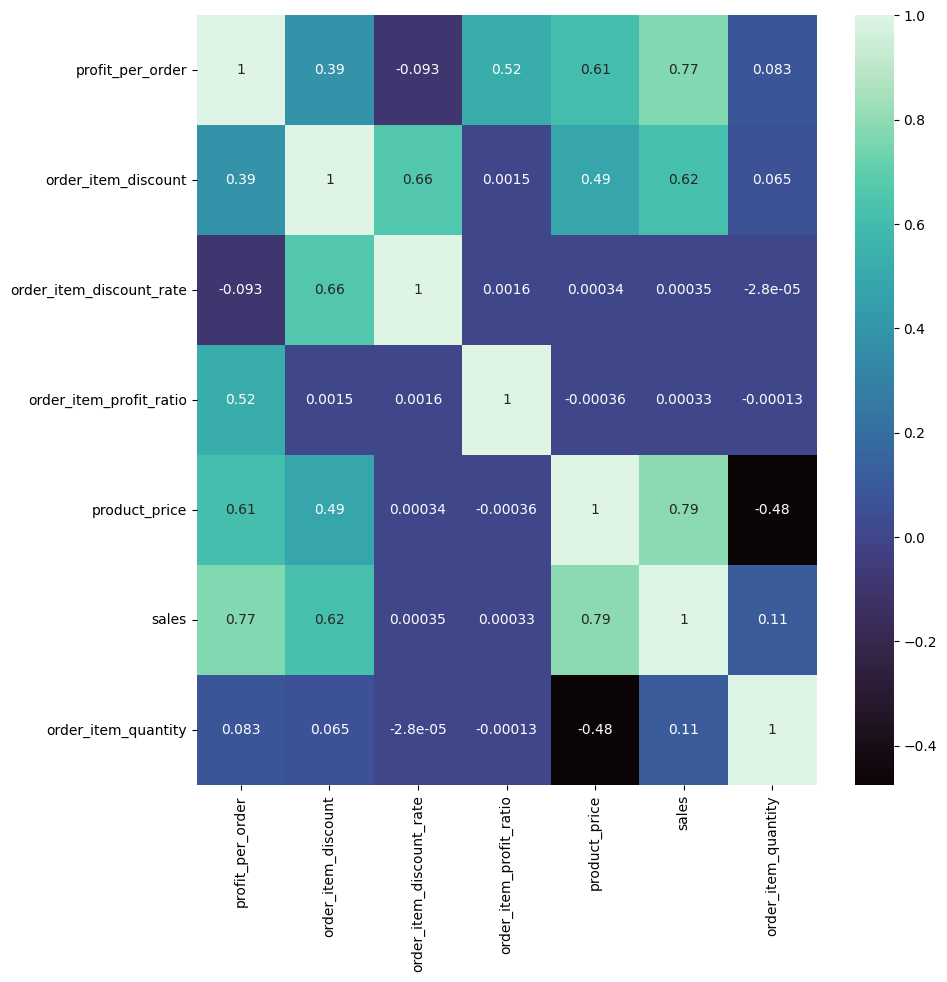

In [17]:
# creating heatmap about meaningful numeric variables
cmap = sns.color_palette("mako", as_cmap=True)
f,ax = plt.subplots(figsize=(10,10))
corr = sns.heatmap(supply_chain[['profit_per_order','order_item_discount', 'order_item_discount_rate', 'order_item_profit_ratio', 'product_price', 'sales', 'order_item_quantity']].corr(), annot = True, ax = ax, cmap = cmap)

### Observations
- order quantity seems to be in moderate negative correlation with price, suggesting that it is unlikely for customers to order more than one expensive product at one time.
- Discount amounts also show a moderate correlation with profit per order and sales. This seems interesting on surface but probably caused by generally more expensive products having bigger discounts. The ever so slight negative correlation of profit and discount rate confirms this
- discount rate and profit, and even profit ratio do not seem to influence each other a lot, meaning discounts are given out in  manner that does not cut into profits
- product price and profit per order show a pretty strong correlation, meaning that selling more expensive products creates more profit, at least on an order-by-order basis.

<AxesSubplot: xlabel='product_price', ylabel='order_item_quantity'>

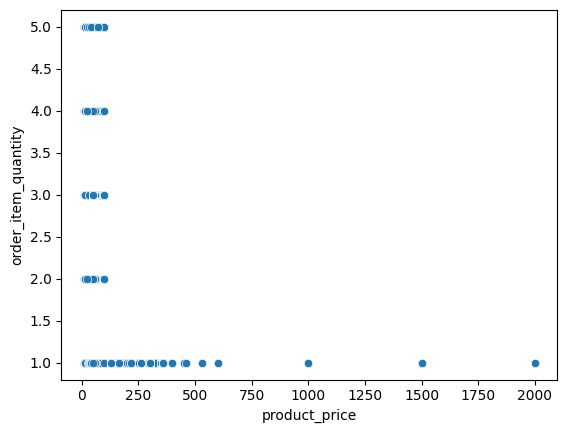

In [18]:
# product price and order quantity
sns.scatterplot(x = 'product_price', y = 'order_item_quantity', data = supply_chain)


### Observations
- it is clearly visible, that only products below ~200$ get ordered in higher quantities

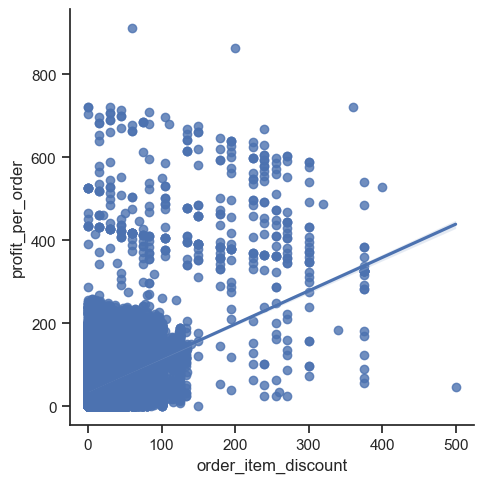

In [19]:
# discount and profit
sns.set(style="ticks")
sns.lmplot(x = 'order_item_discount', y = 'profit_per_order', data = supply_chain)

### Observations
- The scatterplot shows, that the correlation is mostly just due to higher-priced products having bigger discounts

### Pair plots

In [20]:
# Creating subset of numeric columns
numeric_columns = supply_chain[['profit_per_order', 'order_item_discount_rate', 'product_price', 'sales', 'order_item_quantity']]

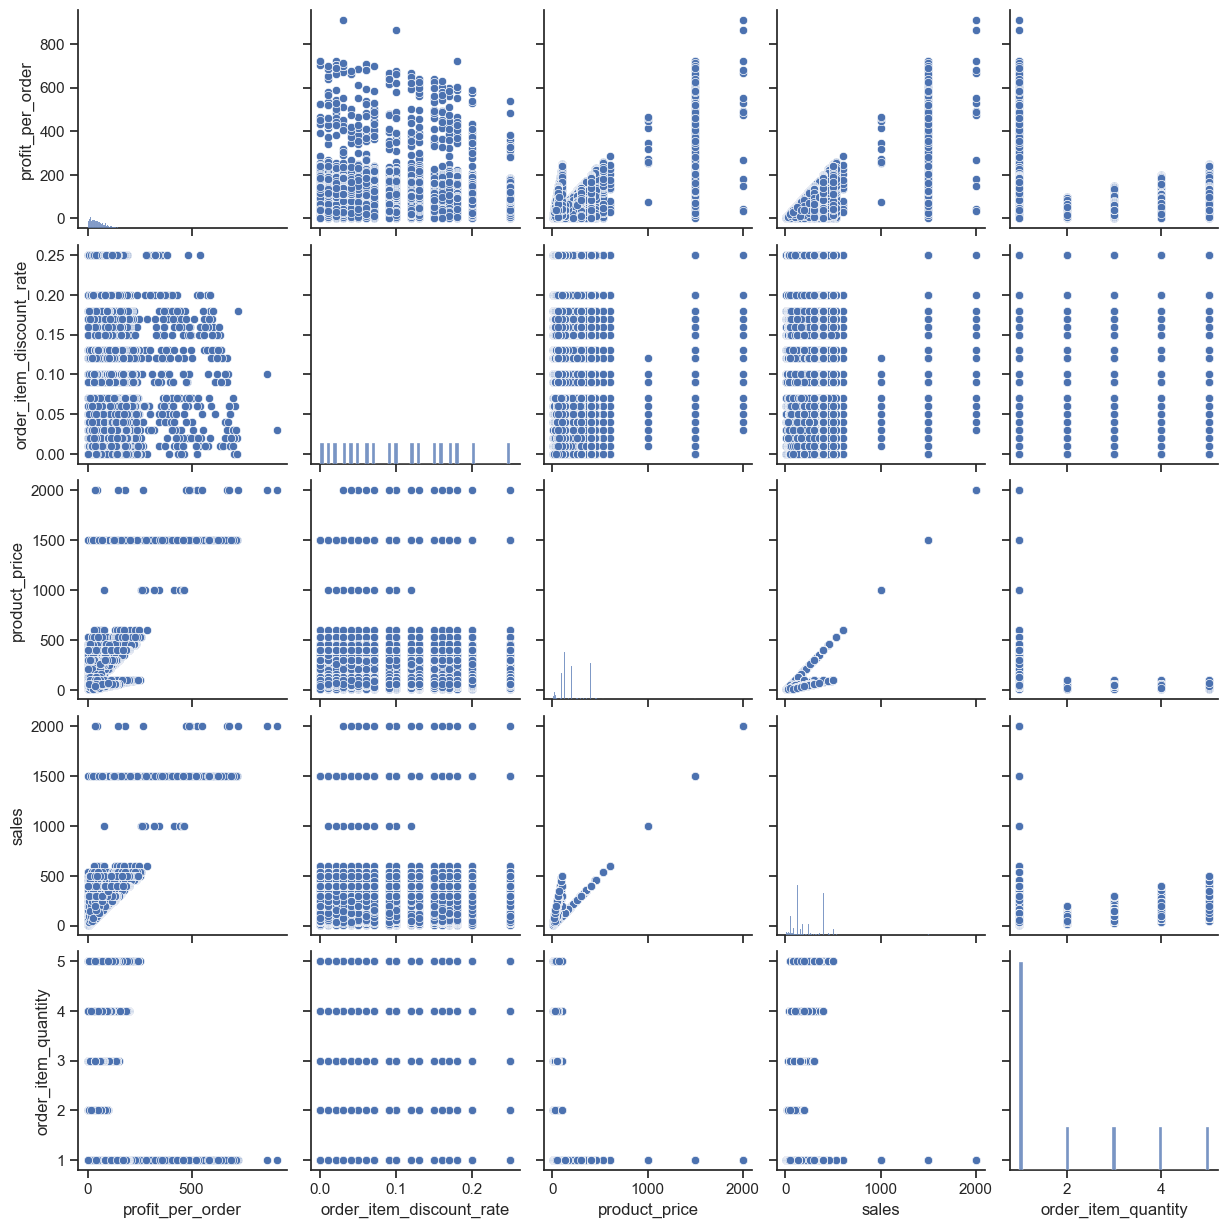

In [21]:
# creating the pairplots
sns.pairplot(numeric_columns)

### Observations
- as of now, none of these seem particularly promising. However, with some classicfication, insight might be found
- some classification ideas: price ranges, discount ratio ranges.

### Categorical plots

In [22]:
supply_chain.columns

Index(['type', 'shipping_days_real', 'shipping_days_scheduled',
       'profit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_id', 'customer_segment', 'customer_state',
       'department_id', 'department_name', 'market', 'order_city',
       'order_country', 'order_date', 'order_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_region', 'order_state',
       'order_status', 'product_id_card', 'product_name', 'product_price',
       'product_status', 'shipping_date', 'shipping_mode'],
      dtype='object')

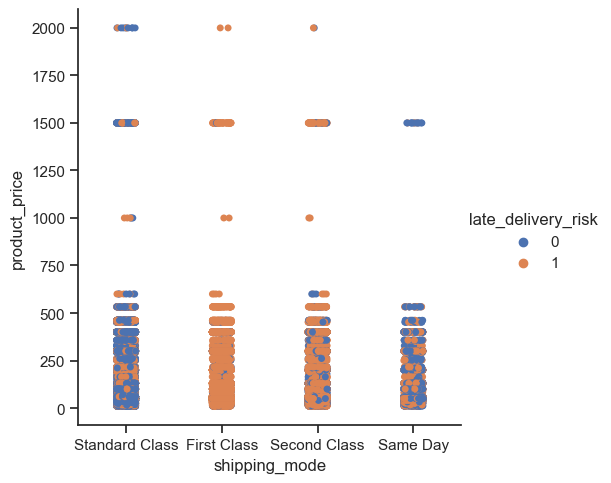

In [23]:

sns.catplot(data=supply_chain, x = 'shipping_mode', y = 'product_price', hue='late_delivery_risk')

### Observations
- First and second class shipping methods seem to hold the risk of late deliveries

C:\Users\Richárd\AppData\Local\Temp\ipykernel_13908\689910540.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  departments_histogram.set_xticklabels(departments_histogram.get_xticklabels(), rotation=45)


[Text(0, 0, 'Fitness'),
 Text(1, 0, 'Apparel'),
 Text(2, 0, 'Golf'),
 Text(3, 0, 'Footwear'),
 Text(4, 0, 'Outdoors'),
 Text(5, 0, 'Fan Shop'),
 Text(6, 0, 'Technology'),
 Text(7, 0, 'Book Shop'),
 Text(8, 0, 'Discs Shop'),
 Text(9, 0, 'Pet Shop'),
 Text(10, 0, 'Health and Beauty ')]

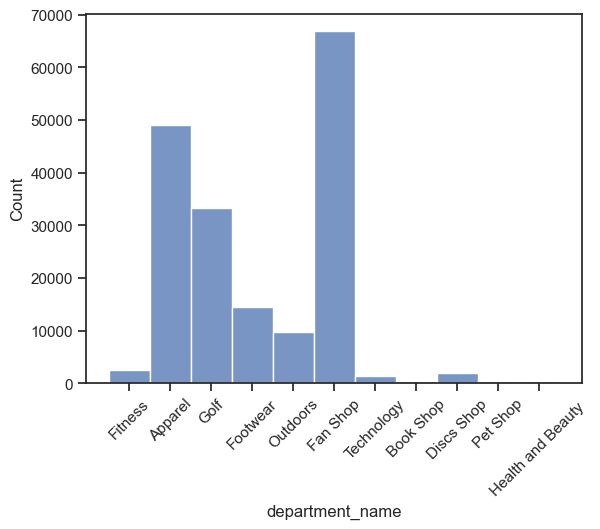

In [24]:
# distribution of orders accross departments
departments_histogram = sns.histplot(data = supply_chain['department_name'])
departments_histogram.set_xticklabels(departments_histogram.get_xticklabels(), rotation=45)

#### Revisiting earlier questions:
- What could cause shipments to be late: *First and second class shipping methods seem to hold the risk of late deliveries*
- Are some products/groups more profitable than others and if so is there a pattern/way to classify them?: *There are big differences between departments in terms of how much they are being ordered.*

Some follow-up questions:
- How *profitable* are the different departments? 
- What customer groups/geographical groups choose to order first/second class shipping modes


#### Some hypothesises:
- There are differences in geographical ordering habits
- Different regions have different market values
- Geographical location does impact the chance of late deliveries
- Some consumer segments drive significantly more profit than others

In [25]:
supply_chain.to_pickle(os.path.join(path, 'clean_supply_chain_v2.pkl'))